In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display

import tensorflow_hub as hub
import bert
from tensorflow.keras.models import Model       # Keras is the new high level API for TensorFlow
import math

In [2]:
print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

TF version:  2.3.1
Hub version:  0.10.0


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


##### Preprocess the input sentences

In [4]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [5]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


##### hyper parameter

In [6]:
hparas = {
    'MAX_SEQ_LENGTH': 20,                       # maximum sequence length
    'EMBED_DIM': 256,                                  # word embedding dimension
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': 128,                     # number of RNN neurons
    'CODE_DIM':128,                                     # dim of code after both rnn_encoder and cnn_encoder 
    'Z_DIM': 512,                                            # random noise z dimension
    'DENSE_DIM': 128,                                  # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                      # render image size
    'BATCH_SIZE': 64,
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 500,
    'N_SAMPLE': 70504 ,                          # size of training data
    'PRINT_FREQ': 1,                                    # printing frequency of loss
    'WClipLo': -2,
    'WClipHi': 2
}

##### dataset

In [7]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [8]:
df.head(5)

,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


In [9]:
num_total_captions = 0

for i in range(len(df.iloc[:,0])):
    num_total_captions += len(df.iloc[i][0])
print(num_total_captions)

70504


##### We use every sentence (1~10 sentences) corresponding to the image to create the dataset.

In [ ]:
filenames = data_path + '/text2ImgData.pkl'

# load the training data into two NumPy arrays
df = pd.read_pickle(filenames)
captions = df['Captions'].values
image_paths = df['ImagePath'].values
caption = []
image_path = []
# each image has 1 to 10 corresponding captions
# we choose one of them randomly for training
for i in range(len(captions)):
    im_path = image_paths[i]
    for c in captions[i]:
        caption.append (c)
        image_path.append (im_path)
#  caption.append(random.choice(captions[i]))
caption = np.asarray(caption)
caption = caption.astype(np.int)

print(caption.shape)
print(len(image_path))

##### Helper function for generating training dataset.

In [ ]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator_fast(image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = (img*2 ) - 1 # -1 to 1
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    return img

 ##### Read all images first to speed up training process. Won't get stucked in cpu and slow down the training time.

In [ ]:
for i in range(len(image_path)):
    img = training_data_generator_fast(image_path[i])
    if i==0:
        all_img = img
        all_img = tf.expand_dims(all_img, 0)
    else:
        all_img = tf.concat([all_img, tf.expand_dims(img, 0)], 0)
    
print(all_img.shape)

In [ ]:
caption = tf.cast(caption, tf.int32)

##### 'dataset_generator_fast' is the function for creating dataset which uses every sentence corresponding to the image, whereas 'dataset_generator_random' is the function for creating dataset which only randomly picks a sentence from every sentence corresponding to the image. In the final decision, we use 'dataset_generator' for creating dataset.

In [ ]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3
def dataset_generator_fast(batch_size, caption, image_path):
    dataset = tf.data.Dataset.from_tensor_slices((image_path, caption))
    dataset = dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=10000)
    hparas['N_SAMPLE'] = 70504 
    return dataset


def dataset_generator_random(filenames, batch_size, data_generator):
    # load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    captions = df['Captions'].values
    caption = []
    # each image has 1 to 10 corresponding captions
    # we choose one of them randomly for training
    for i in range(len(captions)):
        caption.append(random.choice(captions[i]))
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    image_path = df['ImagePath'].values
    
    # assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == image_path.shape[0]
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, image_path))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=5000)
#     tf.print(caption.shape[0])
    return dataset

In [ ]:
dataset = dataset_generator_fast(hparas['BATCH_SIZE'],caption, all_img )
fake_dataset = dataset_generator_fast(hparas['BATCH_SIZE']  , caption, all_img)

In [ ]:
dataset

#####  Conditional gan model - Text Encoder. The same architecture of the RNN encoder we've trained.

In [23]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, GRU, Embedding,Dense
from tensorflow.keras.models import Sequential

class RnnEncoder(tf.keras.Model):
    """
    
    """
    def __init__(self, hparas):
        super(RnnEncoder, self).__init__()
        self.hparas = hparas
        
        # params 
        self.batch_size = self.hparas['BATCH_SIZE']
        self.code_dim = self.hparas['CODE_DIM'] 

        # layers 
        # shape = (batch_size, max_lenth)
        self.embedding = Embedding(self.hparas['VOCAB_SIZE'], self.hparas['EMBED_DIM'])
        # shape = (batch_size, max_lenth, embedding_dim)
        self.RENet = GRU(self.hparas['RNN_HIDDEN_SIZE'], return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        # shape = (batch_size, rnn_hidden_size)
        
        # self.dense = Dense(self.code_dim) 
        
    def call(self, text, hidden):
        text_embed = self.embedding (text) 
        whole_sequence_output, final_state = self.RENet(text_embed, initial_state  = hidden)
        # whole_sequence_output => shape = (batch_size, 20, RNN_HIDDEN_SIZE)
        return whole_sequence_output[:, -1, :]                   # result of the last input
    
    def initialize_hidden_state(self, current_batch_size ):
        # return the initial hidden state 
        return tf.zeros((current_batch_size, self.hparas['RNN_HIDDEN_SIZE']))

#####  Conditional gan model - Generator. Based on the paper of conditional GAN, we designed the architecture of generator. It is worth mentioning that when using batch normalization layer, we need to add another parameter 'training'. When training, we need to set 'training = True', whereas when inferencing, we need to set 'training = False'. At the beginning, we didn't set this parameter, and the model can't be trained. After a long period of time of debugging, we finally found this error. 

In [24]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, ReLU
from tensorflow.keras.models import Sequential
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        
        # parameters 
        self.n_filter = 64
        self.n_channel = self.hparas['IMAGE_SIZE'][2]

        # layers 
        # shape = (batch_size, code_dim)
        self.d0 = Dense(self.hparas['DENSE_DIM'])
        self.act0 = ReLU()
        # shape = (batch_size, dense_dim)
            
        # shape = (batch_size, 1, 1, noise_dim + dense_dim)
        self.con1 = Conv2DTranspose(filters = self.n_filter * 8, kernel_size=4,  strides = 1, padding = "valid")
        self.bat1 = BatchNormalization()
        self.act1 = ReLU()
        # shape = (batch_size, 4, 4, n_filter*8)
        self.con2 = Conv2DTranspose(filters = self.n_filter * 4, kernel_size=4,  strides = 2, padding = "same")
        self.bat2 = BatchNormalization()
        self.act2 = ReLU()
        # shape = (batch_size, 8, 8, n_filter*4)
        self.con3 = Conv2DTranspose(filters = self.n_filter * 2, kernel_size=4,  strides = 2, padding = "same")
        self.bat3 = BatchNormalization()
        self.act3 = ReLU()
        # shape = (batch_size, 16, 16, (n_filter*2)
        self.con4 = Conv2DTranspose(filters = self.n_filter * 1, kernel_size=4,  strides = 2, padding = "same")
        self.bat4 = BatchNormalization()
        self.act4 = ReLU()
        # shape = (batch_size, 32, 32, n_filter)
        self.con5 = Conv2DTranspose( filters = self.n_channel, kernel_size = 4, strides = 2, padding = "same")
        # shape = (batch_size, 64, 64, n_channel )     
        
        
    def call(self, text, noise_z, training = True):
        
        text = self.d0(text)
        text = self.act0(text)
        
        # concatenate input text and random noise
        text_concat = tf.concat([noise_z, text], axis=1)
        #  text_concat = self.dense_concat(text_concat)
        text_concat = tf.expand_dims(text_concat, axis = 1)
        text_concat = tf.expand_dims(text_concat, axis = 1)                       # shape = (batch_size, 1, 1, noise_dim + dense_dim)
        #  text_concat = tf.reshape(text_concat, [-1, 4, 4, 64*8])
        
        x = self.con1(text_concat)
        x = self.bat1(x, training = training)
        x = self.act1(x)

        x = self.con2(x)
        x = self.bat2(x, training = training)
        x = self.act2(x)

        x = self.con3(x)
        x = self.bat3(x, training = training)
        x = self.act3(x)

        x = self.con4(x)
        x = self.bat4(x, training = training)
        x = self.act4(x)

        logits = self.con5(x)
        
        output = tf.keras.activations.tanh(logits)

        return  output

#####  Conditional gan model - Discriminator. Based on the paper of conditional GAN, we designed the architecture of discriminator. The parameter 'training' of batch normalization layer still needs to be set. Otherwise, the weights of batch normalization layer won't be updated. 

In [25]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Dense, Flatten
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        
        # parameters
        self.n_filter = 64
        
        # layers 
        # shape = (batch_size, code_size)
        self.d0 = Dense(self.hparas['DENSE_DIM'])
        self.act0 = LeakyReLU()
        # shape = (batch_size, dense_size)
 
        # shape = (batch_size, 64, 64, 3) 
        self.con1 = Conv2D(filters = self.n_filter* 1 , kernel_size=4,  strides = 2, padding='same')
        self.act1 = LeakyReLU()
        # shape = (batch_size, 32, 32, n_filter) 
        self.con2 = Conv2D(filters = self.n_filter* 2 , kernel_size=4,  strides = 2, padding='same')
        self.bat2 = BatchNormalization()
        self.act2 = LeakyReLU()
        # shape = (batch_size, 16, 16, n_filter*2) 
        self.con3 = Conv2D(filters = self.n_filter* 4 , kernel_size=4,  strides = 2, padding='same')
        self.bat3 = BatchNormalization()
        self.act3 = LeakyReLU()
        # shape = (batch_size, 8, 8, n_filter*4) 
        self.con4 = Conv2D(filters = self.n_filter* 8 , kernel_size=4,  strides = 2, padding='same')
        self.bat4 = BatchNormalization()
        self.act4 = LeakyReLU()
        # shape = (batch_size, 4, 4, n_filter*8) 

        self.DNet_2 = Conv2D(filters = 1, kernel_size = 4, strides = 4, padding='same')
        

    def call(self, img, text, training = True):

        text = self.d0(text)
        text = self.act0(text)
        
        text = tf.expand_dims(text, axis = 1)
        text = tf.expand_dims(text, axis = 1)
        text = tf.tile(text, [1, 4, 4, 1])
        
        
        x = self.con1(img)
        x = self.act1(x)

        x = self.con2(x)
        x = self.bat2(x, training = training)
        x = self.act2(x)

        x = self.con3(x)
        x = self.bat3(x, training = training)
        x = self.act3(x)

        x = self.con4(x)
        x = self.bat4(x, training = training)
        intermidiate = self.act4(x)
        
        # concatenate intermidiate with text_embed
        concat_embed = tf.concat([intermidiate, text], axis=3)   # concat in channel-axis , shape = (batch_size, 4, 4, n_filter*8 + dense_dim)
        
        logits = self.DNet_2 (concat_embed)
        output = tf.nn.tanh(logits)  # output shape = (batch_size, 1, 1, 1) 
        return logits, output

In [26]:
rnn_encoder = RnnEncoder(hparas)
generator = Generator(hparas)
discriminator = Discriminator(hparas)

##### Loss function and optimization

##### This penalty term aims to help the model to generate more diverse image output. However, after implementing this term, we didn't get better result. Therefore, we didn't add this term the our loss in the final model.

In [27]:
# penalty for without diversity 
def d_penalty(noise, test_noise, fake_images, fake_test_images):
    image_diff = tf.abs(fake_images - fake_test_images)
    image_diff = tf.sqrt(tf.reduce_sum(image_diff ** 2, axis = (1, 2, 3)))
                         
    noise_diff = tf.abs(noise - test_noise)
    noise_diff = tf.sqrt(tf.reduce_sum(noise_diff ** 2, axis = (1, )))
                         
    return tf.reduce_mean(image_diff / noise_diff)
    
    

In [28]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

##### The following loss functions are loss of DCGAN and WGAN. After trial and error, we found out that WGAN can achieve a little bit better score. 

In [29]:
def discriminator_loss(real_logits, fake_logits, wrong_logits):
    real_loss = cross_entropy(tf.ones_like(real_logits), real_logits) # real logits ->  1
    fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits) # fake logits ->  0
    wrong_loss = cross_entropy(tf.zeros_like(wrong_logits), wrong_logits) # wrong logits -> 0
    
    total_loss = real_loss +  0.5* ( fake_loss + wrong_loss ) 
    return total_loss

def generator_loss(fake_logits):
    return  ( cross_entropy(tf.ones_like(fake_logits), fake_logits) ) # fake logits ->  1

In [30]:
def discriminator_Wloss(real_logits, fake_logits, wrong_logits):
    real_loss = tf.reduce_mean(real_logits) 
    fake_loss = tf.reduce_mean(fake_logits) 
    wrong_loss = tf.reduce_mean(wrong_logits)
    
    total_loss = -( real_loss -  ( fake_loss + wrong_loss ) )
    return total_loss

def generator_Wloss(fake_logits):
    fake_loss = -tf.reduce_mean(fake_logits) # fake logits ->  1
    return fake_loss

##### We use seperated optimizers for training generator and discriminator
##### we tuned the hyper-parameter beta_1 of adam optimizer from 0.99 to 0.5, and the performance elevate slightly. We also tried sgd as optimizer of discriminator, howerer the performance did not improve.

In [31]:
generator_optimizer =  tf.keras.optimizers.Adam(hparas['LR'], beta_1=0.5)
discriminator_optimizer =  tf.keras.optimizers.Adam(hparas['LR'], beta_1=0.5)

##### Function for training the generator and discriminator. 

In [32]:
# hyper - params
d_lamda = 1
@tf.function
def  G_Train(real_images, right_caption, wrong_caption):
    
    # rnn inital state 
    hidden = rnn_encoder.initialize_hidden_state(real_images.shape[0]) # real_image[0] = batch_size

    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    
    with tf.GradientTape() as gen_tape:
        # text encoder 
        right_embed = rnn_encoder(right_caption, hidden)
        wrong_embed = rnn_encoder(wrong_caption, hidden)
        # generator 
        fake_images = generator(right_embed, noise, training = True)
        
        # discriminator 
        real_logits, real_output = discriminator(real_images, right_embed,  training = True) # real image + pair data
        fake_logits, fake_output = discriminator(fake_images, right_embed,  training = True) # fake image 
        wrong_logits, wrong_output = discriminator(real_images, wrong_embed,  training = True) # real image + unpait data
        
        g_loss = generator_Wloss(fake_logits)
        d_loss = discriminator_Wloss(real_logits, fake_logits, wrong_logits)
        

    grad_g = gen_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
    
    return g_loss, d_loss

@tf.function
def  D_Train(real_images, right_caption, wrong_caption):
    
    # rnn inital state 
    hidden = rnn_encoder.initialize_hidden_state(real_images.shape[0]) # real_image[0] = batch_size

    # random noise for generator
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    
    with tf.GradientTape() as disc_tape:
        # text encoder 
        right_embed = rnn_encoder(right_caption, hidden)
        wrong_embed = rnn_encoder(wrong_caption, hidden)
        # generator 
        fake_images = generator(right_embed, noise, training = True)
#         fake_test_images = generator(right_embed, test_noise, training = False)  # diversity !!!
        
        # discriminator 
        real_logits, real_output = discriminator(real_images, right_embed, training = True) # real image + pair data
        fake_logits, fake_output = discriminator(fake_images, right_embed, training = True) # fake image 
        wrong_logits, wrong_output = discriminator(real_images, wrong_embed, training = True) # real image + unpait data
        
        g_loss = generator_Wloss(fake_logits) 
        d_loss = discriminator_Wloss(real_logits, fake_logits, wrong_logits)
        
        
    grad_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))
        
    return g_loss, d_loss

In [33]:
# ratio of training step D:G = 5:1
GANTrain = (
       D_Train,
       D_Train,
       D_Train,
       D_Train,
       D_Train,
       G_Train,
)

GANCritic = len(GANTrain)

##### Function for testing.

In [34]:
@tf.function
def test_step(caption, noise):
#     tf.print(caption.shape[0])
    # rnn inital state 
    hidden = rnn_encoder.initialize_hidden_state(caption.shape[0]) # real_image[0] = batch_size
    
    text_embed= rnn_encoder(caption, hidden)
    fake_image = generator(text_embed, noise, training = False)

    return fake_image

##### Visualization

In [35]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [36]:
def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    dataset = dataset.batch(batch_size)
    return dataset

In [37]:
ni = int(np.ceil(np.sqrt(hparas['BATCH_SIZE'])))
sample_size = hparas['BATCH_SIZE'] 
sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."] * int(sample_size/ni) + \
                  ["this flower has petals that are yellow, white and purple and has dark lines"] * int(sample_size/ni) + \
                  ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + \
                  ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + \
                  ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + \
                  ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + \
                  ["this flower has petals that are blue and white."] * int(sample_size/ni) +\
                  ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)

sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(len(sample_sentence), hparas['Z_DIM'])).astype(np.float32)

for i, sent in enumerate(sample_sentence):
    sample_sentence[i] = sent2IdList(sent)
sample_sentence = sample_generator(sample_sentence, hparas['BATCH_SIZE'])

##### Checkpoint

In [41]:
# ckpt for gan
GAN_CKPT_DIR  = './ckpts/gan_2/'
gan_ckpt= tf.train.Checkpoint(discriminator_optimizer=discriminator_optimizer,
                                                 generator_optimizer=generator_optimizer,
                                                 generator=generator,
                                                 discriminator=discriminator)
gan_ckpt_manager = tf.train.CheckpointManager(gan_ckpt, GAN_CKPT_DIR, max_to_keep=100)
start_epoch = 0
gan_ckpt.restore(GAN_CKPT_DIR + './ckpt-43')

In [42]:
# ckpt for encoder
ENCODER_CKPT_DIR = './ckpts/rnn_encoder'
encoder_ckpt = tf.train.Checkpoint(rnn_encoder = rnn_encoder)
encoder_ckpt_manager = tf.train.CheckpointManager(encoder_ckpt, ENCODER_CKPT_DIR, max_to_keep=100)
encoder_ckpt.restore( ENCODER_CKPT_DIR+ './ckpt-148')

##### Training.

In [ ]:
g_ep_loss = [0]*hparas['N_EPOCH']
d_ep_loss = [0]*hparas['N_EPOCH']

def train(dataset, epochs):
    steps_per_epoch = int(hparas['N_SAMPLE'] / hparas['BATCH_SIZE'])
    
    ctr = 0
    for epoch in range(start_epoch, hparas['N_EPOCH']):
        g_total_loss = 0
        d_total_loss = 0
        start = time.time()
        
        # create new dataset 
#         dataset = dataset_generator(data_path + '/text2ImgData.pkl', hparas['BATCH_SIZE'], training_data_generator)
#         fake_dataset = dataset_generator(data_path + '/text2ImgData.pkl', hparas['BATCH_SIZE'], training_data_generator)
        
        
        for (image, right_caption), ( _,  wrong_caption) in zip (dataset, fake_dataset):
            g_loss, d_loss = GANTrain[ctr](image, right_caption, wrong_caption)
            ctr += 1
            
            g_total_loss += g_loss
            d_total_loss += d_loss
            
            if ( ctr == GANCritic): ctr = 0
        
        
        g_ep_loss[epoch] = (g_total_loss / steps_per_epoch)
        d_ep_loss[epoch] = (d_total_loss / steps_per_epoch)
        
        time_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)
            
        print("Epoch {}, gen_loss: {:.4f}, disc_loss: {:.4f}".format(epoch+1,
                                                                     g_total_loss/steps_per_epoch,
                                                                     d_total_loss/steps_per_epoch))
        print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))
        
        # save checkpoint for each epoch
        if (epoch+1) % 10 == 0:
            save_path = gan_ckpt_manager.save()
            print("Saved checkpoint for epoch {}: {}".format(epoch, save_path))
    
        
        # visualization
        if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
            for caption in sample_sentence:
                fake_image = test_step(caption, sample_seed)
            save_images(fake_image, [ni, ni], './samples/demo/train_{:02d}.jpg'.format(epoch))

In [ ]:
train(dataset, hparas['N_EPOCH'])

##### This training record is not our final score because we changed the loss function but we got a terrible result. Therefore, the final score is chose from one of our previously stored checkpoint.

##### Evaluation. 

In [ ]:
def testing_data_generator(caption, index):
    caption = tf.cast(caption, tf.float32)
    return caption, index

def testing_dataset_generator(batch_size, data_generator):
    data = pd.read_pickle('./dataset/testData.pkl')
    captions = data['Captions'].values
    caption = []
    for i in range(len(captions)):
        caption.append(captions[i])
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    index = data['ID'].values
    index = np.asarray(index)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

In [ ]:
testing_dataset = testing_dataset_generator(hparas['BATCH_SIZE'], testing_data_generator)

In [ ]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])

##### Inference

In [ ]:
def inference(dataset):
#     hidden = rnn_encoder.initialize_hidden_state(hparas['BATCH_SIZE'])
    sample_size = hparas['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
    
    step = 0
    start = time.time()
    for captions, idx in dataset:
        if step > EPOCH_TEST:
            break
        
        fake_image = test_step(captions, sample_seed)
        step += 1
        for i in range(hparas['BATCH_SIZE']):
            plt.imsave('./inference/demo/inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)
            
    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [40]:
gan_ckpt.restore(GAN_CKPT_DIR + './ckpt-43')

In [ ]:
inference(testing_dataset)

##### Calculate average score by ourself. Need to execute "python inception_score.py ../inference/demo ../score_demo.csv 39" first.

In [ ]:
import csv

total_score = 0
with open('score_demo.csv', newline='') as csvfile:
    next(csvfile)
    rows = csv.reader(csvfile)

    for row in rows:
        total_score += float(row[0])

print(total_score/819)

##### Demo

In [43]:
def visualize(idx):
    fig = plt.figure(figsize=(14, 14))
    
    for count, i in enumerate(idx):
        loc = np.where(i==index)[0][0]
        text = ''
        for word in captions[loc]:
            if id2word_dict[word] != '<PAD>':
                text += id2word_dict[word]
                text += ' '
        print(text)
        
        path = './inference/demo/inference_{:04d}.jpg'.format(i)
        fake_iamge = plt.imread(path)
        
        plt.subplot(7, 7, count+1)
        plt.imshow(fake_iamge)
        plt.axis('off')

##### we choose 1277, 6964, 2848, 1568, 2765

the petals of the flower are pink in color and have green leaves 
this flower has start shaped purple petals as its main feature 
the petals of the flower are red in color and have a center that is made of yellow anthers 
this flower is pink in color with petals that are leaf like 
this flower has petals that are purple and folded together 


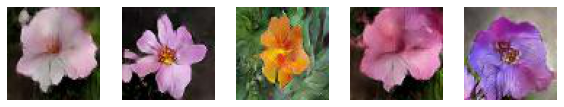

In [54]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values
index = data['ID'].values
idx = [1277, 6964, 2848, 1568, 7137]

visualize(idx)

##### use different noise to generate flowers

In [55]:
num_of_samples = 5
sample_sentence = ["the petals of the flower are pink in color and have green leaves"] * num_of_samples+ \
                  ["this flower has start shaped purple petals as its main feature"] * num_of_samples + \
                  ["the petals of the flower are red in color and have a center that is made of yellow anthers"] * num_of_samples + \
                  ["this flower is pink in color with petals that are leaf like"] * num_of_samples + \
                  ["this flower has petals that are purple and folded together "] * num_of_samples

sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(len(sample_sentence), hparas['Z_DIM'])).astype(np.float32)

for i, sent in enumerate(sample_sentence):
    sample_sentence[i] = sent2IdList(sent)
sample_sentence = sample_generator(sample_sentence, hparas['BATCH_SIZE'])

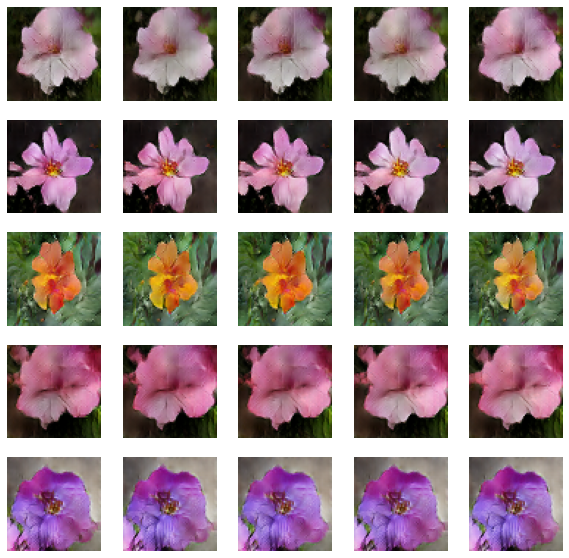

In [56]:
for caption in sample_sentence:
    fake_image = test_step(caption, sample_seed)

fig = plt.figure(figsize=(10, 10))
for count, image in enumerate(fake_image):
    plt.subplot(5, 5, count+1)
    plt.imshow(image*0.5 + 0.5)
    plt.axis('off')

##### report summary
##### I wrote some comments and explanations of our implementaion on the above cells, so here i just summersize what we had tried and our thought.
##### 1. data augmentation: we use every pair of data as our dataset.
##### 2. rnn encoder: we evaluate the quality of rnn encoder via the similarity of output of cnn encoder  and output of rnn encoder.
##### 3. our model: use dc-gan and wgan. Though the difference is small. wgan outperformed dc gan.
##### 4. other attempts: diversity penalty. different optimizer. optimizer parameter tuning. weights of different penalties in gan-training step.